In [1]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.io import write
from pwtools import io

In [2]:
import subprocess

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

# Quantum Espresso Inputs

In [5]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [6]:
input_data_relax = {
    'calculation': 'vc-relax', # A string describing the task to be performed.
    'cell_dofree': 'ibrav',
}

In [7]:
input_data_static = {
    'calculation': 'scf', # A string describing the task to be performed.
}

# Workflow

## Structure Optimization

In [8]:
structure = bulk('Al', a=4.15, cubic=True)

In [9]:
write(
    'relax.pwi', 
    structure, 
    Crystal=True, 
    kpts=(3, 3, 3), 
    input_data=input_data_relax, 
    pseudopotentials=pseudopotentials,
    tstress=True, 
    tprnfor=True
)

In [10]:
subprocess.check_output("mpirun -np 1 pw.x -in relax.pwi > relax.pwo", shell=True, universal_newlines=True)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


''

In [11]:
structure_opt = io.read_pw_md('relax.pwo')[-1].get_ase_atoms()
structure_opt

Atoms(symbols='Al4', pbc=False, cell=[4.138949786, 4.138949786, 4.138949786])

## Energy Volume Curve

In [12]:
energy_lst, volume_lst = [], []
for strain in np.linspace(0.9, 1.1, 5):
    structure_strain = structure_opt.copy()
    structure_strain = structure.copy()
    structure_strain.set_cell(structure_strain.cell * strain**(1/3), scale_atoms=True)
    write(
        'strain.pwi', 
        structure_strain, 
        Crystal=True, 
        kpts=(3, 3, 3), 
        input_data=input_data_static, 
        pseudopotentials=pseudopotentials,
        tstress=True, 
        tprnfor=True
    )
    subprocess.check_output("mpirun -np 1 pw.x -in strain.pwi > strain.pwo", shell=True, universal_newlines=True)
    out = io.read_pw_scf('strain.pwo')
    energy_lst.append(out.etot)
    volume_lst.append(out.volume)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


# Result

Text(0, 0.5, 'Energy')

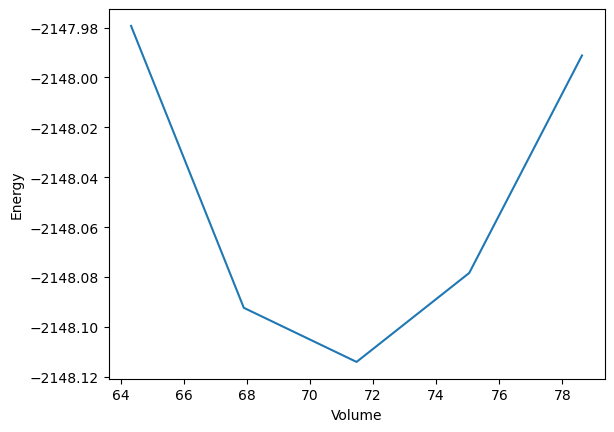

In [13]:
plt.plot(volume_lst, energy_lst)
plt.xlabel("Volume")
plt.ylabel("Energy")